In [29]:
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
from datetime import datetime
import pytz
import json
import matplotlib.pyplot as plt
import numpy as np

In [30]:
def getCurrTime():
    ausTZ = pytz.timezone("Australia/Melbourne")
    arrival = datetime.now(ausTZ)
    current_time = arrival.strftime("%H:%M:%S")
    
    return current_time

### Streaming Data Visualisation

In [31]:
%matplotlib notebook

topic = 'climateTopic'
hostip = "118.139.86.28"

<IPython.core.display.Javascript object>


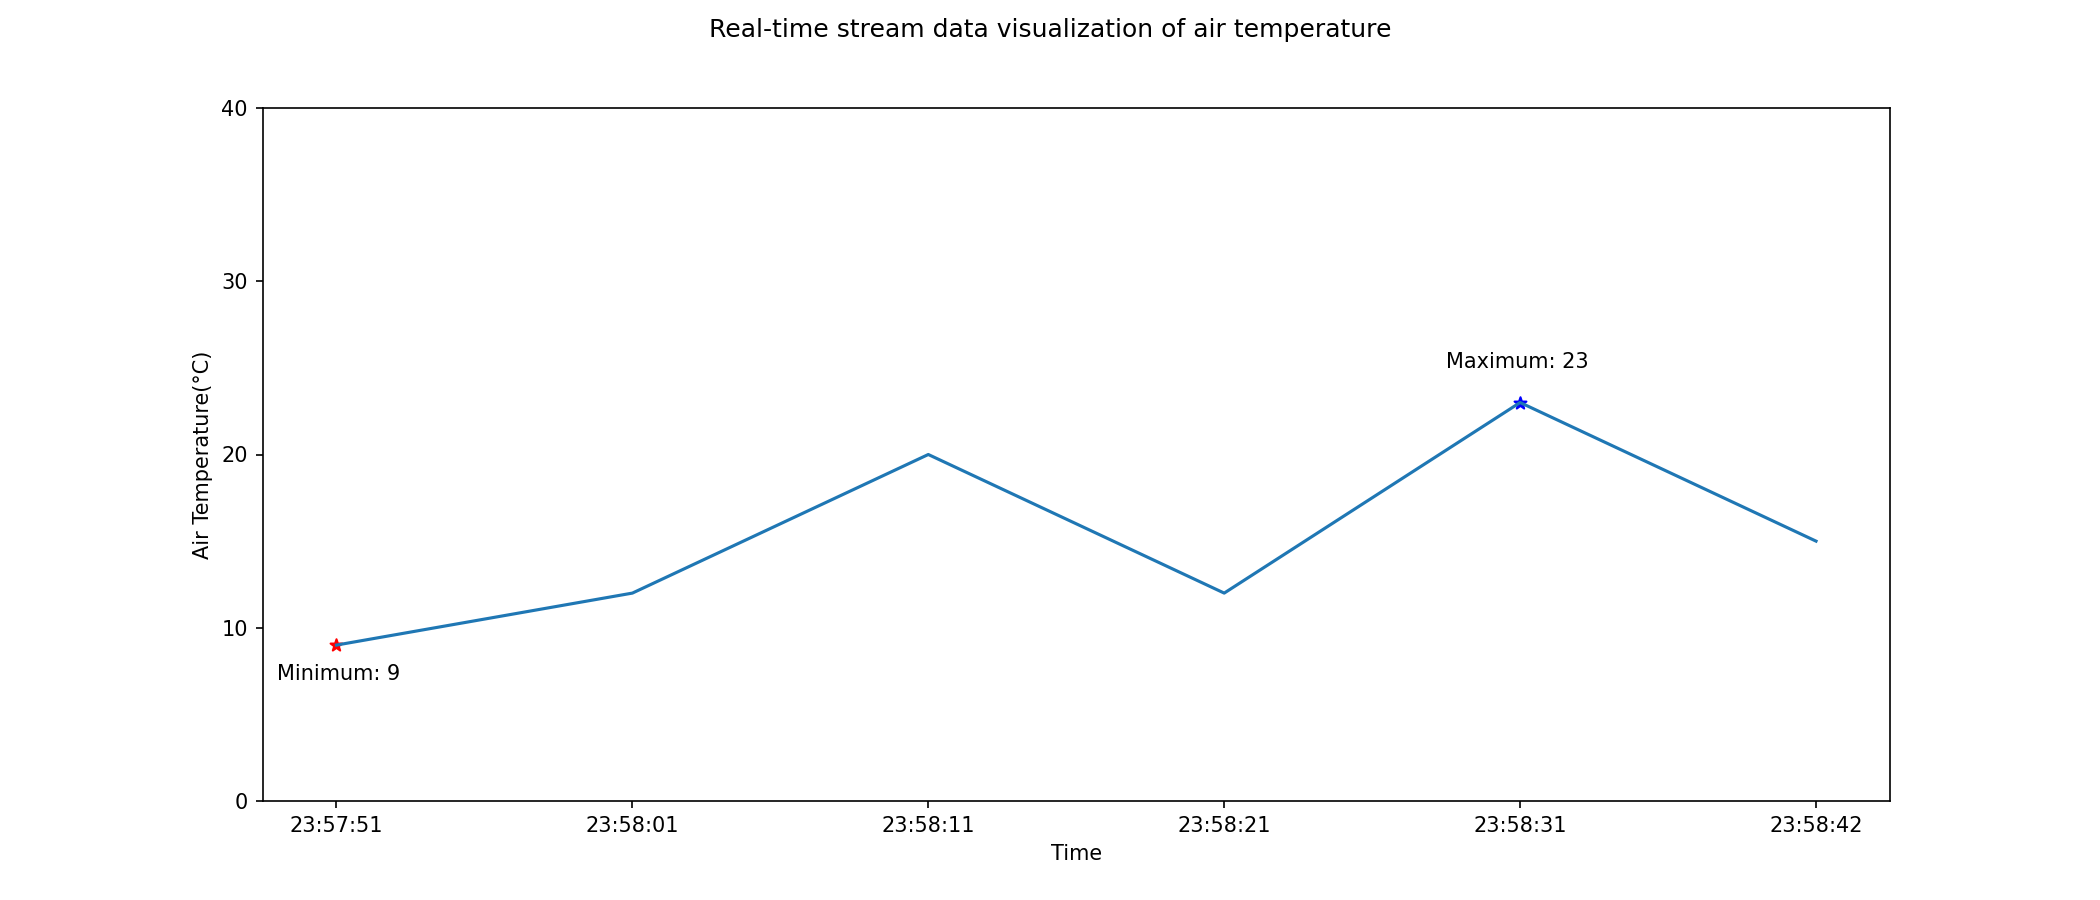

Waiting for messages


KeyboardInterrupt: 

In [81]:
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   auto_offset_reset='latest',
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer
    

def init_plots():
    try:
        width = 14
        height = 6
        fig = plt.figure(figsize=(width,height)) # create a new figure
        ax = fig.add_subplot(111)
        fig.suptitle('Real-time Stream Data Visualization of Air Temperature')
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temperature(°C)')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,10,20,30,40])
        
        #display the figure
        fig.show()
        # drawing on the canvas 
        fig.canvas.draw() 
        return fig, ax
    
    except Exception as ex:
        print(str(ex))
        
        
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(', ')
            data = json.loads(message.value)
            x.append(getCurrTime())
            y.append(int(data["air_temperature"]))
           
            # start plotting when there is 6 data points
            if len(y) > 5:
                ax.clear()
                ax.plot(x, y)     
                
                #get min
                min_x = np.argmin(y)
                min_y = np.min(y)
                
                #get max
                max_x = np.argmax(y)
                max_y = np.max(y)
                
                #plotting the minimum and maximum points
                ax.scatter(min_x, min_y, c='r', marker = "*")
                ax.annotate("Minimum: "+str(min_y), (min_x-.2, min_y-2))
                
                ax.scatter(max_x, max_y, c='blue', marker = "*")
                ax.annotate("Maximum: "+str(max_y), (max_x-.25, max_y+2))
                
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature(°C)')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                
                fig.canvas.draw()
                x.pop(0)
                y.pop(0)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    

## Static Data Visualisation

### Bar Chart of Total Fire Counts Per Hour

In [99]:
!pip install folium
from pymongo import MongoClient
import folium

In [106]:
def queryEachHour(hour):

    results = db.hotspot_stream.aggregate([{"$match":{"datetime":{"$regex" : hour}}}, 
                                           {"$count": "Fire Count"}])
    for doc in results:
        return(doc["Fire Count"])

In [107]:
fireCount = []
hours = []

#get hours from 00:00:00 to 09:00:00
for hour in range(10):
    hour_str = "T0" + str(hour)
    fireCount.append(queryEachHour(hour_str))
    hours.append("0" + str(hour) + ":00:00")

#get hours from 10:00:00 up to 23:00:00
for hour in range(10,24):
    hour_str = "T" + str(hour)
    fireCount.append(queryEachHour(hour_str))   
    hours.append(str(hour) + ":00:00")
    
for index in range(24):
    if fireCount[index] == None:
        fireCount[index] = 0

<IPython.core.display.Javascript object>


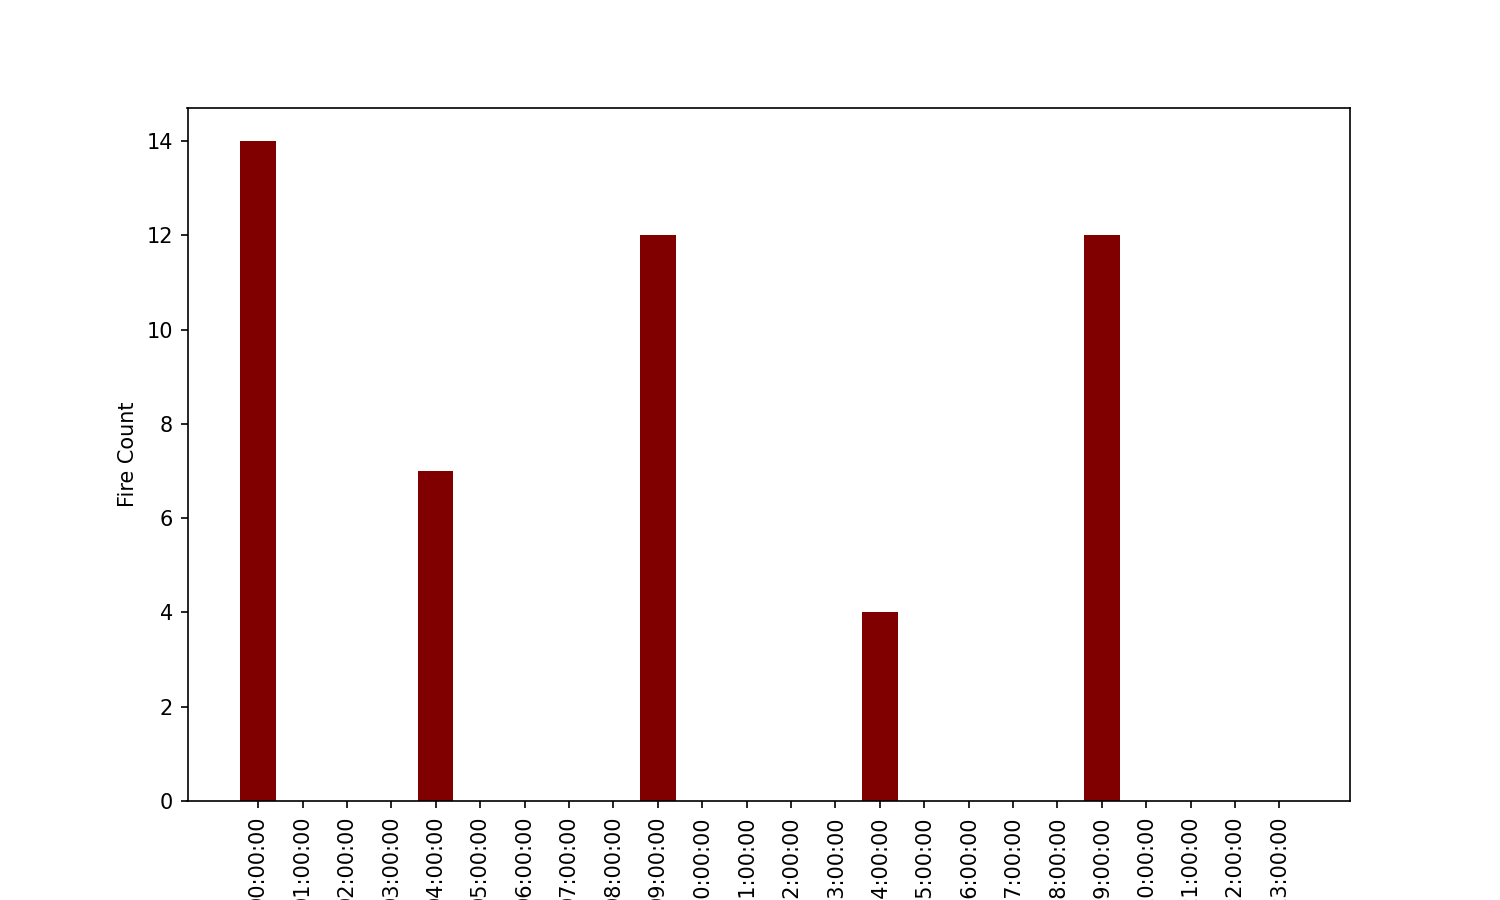

In [108]:
#Visualise total fires per hour

# create new figure
fig = plt.figure(figsize=(10,6)) 
plt.bar(hours, fireCount, color="maroon")
plt.xlabel("Hour")
plt.ylabel("Fire Count")

plt.xticks(rotation = 90)

#show the bar graph
plt.show()

### Map Visualisation

In [109]:
client = MongoClient(hostip, 27017)
db = client.fit3182_assignment_db

In [110]:
def mongoQueries(date): 
    records = db.climate_stream.aggregate([{"$lookup":{"from": "hotspot_stream",
                                                       "localField": "date",
                                                       "foreignField": "date",
                                                       "as": "fires"}},
                                           {"$match": {"date": date}},
                                           {"$project": {"_id":0, "air_temperature":1,"relative_humidity":1,
                                                         "fires.surface_temperature":1, "fires.confidence":1, 
                                                         "date": 1}}])
    for r in records:
        return(r)

In [111]:
naturalList = []
otherList = []

for doc in db.hotspot_stream.find():
    fire_record = {}
    info = mongoQueries(doc["date"])

    if len(info["fires"])>0:
        fire_record["air_temperature"] = str(info["air_temperature"])
        fire_record["relative_humidity"] = str(info["relative_humidity"])
        fire_record["surface_temperature"] = str(info["fires"][0]["surface_temperature"])
        fire_record["confidence"] = str(info["fires"][0]["confidence"])
    
    if doc["fire_cause"] == "natural":
        fire_record["loc"] = (float(doc["latitude"]), float(doc["longitude"]))
        naturalList.append(fire_record)
        
    elif doc["fire_cause"] == "other":
        fire_record["loc"] = (float(doc["latitude"]), float(doc["longitude"]))
        otherList.append(fire_record)


In [112]:
firemap = folium.Map(location= [-37.020100,144.964600], zoom_start = 7)

In [113]:
#iterate through each list 
for nat in naturalList:
    folium.Marker(location=nat["loc"],
                  icon=folium.Icon(color="blue"),
                  tooltip='<b>Air Temperature: </b>' + nat["air_temperature"] + '<br>' + 
                          '<b>Surface Temperature: </b>' + nat["surface_temperature"] + '<br>' + 
                          '<b>Relative Humidity: </b>' + nat["relative_humidity"] + '<br>' +
                          '<b>Confidence: </b>' + nat["confidence"] + '<br>').add_to(firemap)
    
for oth in otherList:
    folium.Marker(location=oth["loc"],
                  icon=folium.Icon(color="red"),
                 tooltip='<b>Air Temperature: </b>' + oth["air_temperature"] + '<br>' + 
                         '<b>Surface Temperature: </b>' + oth["surface_temperature"] + '<br>' +
                         '<b>Relative Humidity: </b>' + oth["relative_humidity"] + '<br>' +
                         '<b>Confidence: </b>' + oth["confidence"] + '<br>' ).add_to(firemap)

In [114]:
#display firemap
firemap